# **Pfam Classifier**

The aim of this notebook is to create a protein classifier that predicts the Pfam family of each protein based on its amino acid sequence.

### **Import requirements and datasets**

In [ ]:
# Install and import requirements
!pip install torch tensorflow transformers sentencepiece h5py opendatasets
import numpy as np
import pandas as pd
import torch
import h5py
import os, time
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE 
from transformers import T5EncoderModel, T5Tokenizer
from tensorflow import keras
from imblearn.under_sampling import RandomUnderSampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.23.1-py3-none-any.whl (5.3 MB)
  Using cached sentencepiece-0.1.97-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
     |████████████████████████████████| 7.6 MB 14.4 MB/s 
     |████████████████████████████████| 163 kB 65.7 MB/s 


In [ ]:
# Download dataset from Kaggle
od.download("https://www.kaggle.com/datasets/googleai/pfam-seed-random-split")

# Kaggle username: yuntzuyin
# Kaggle Key: 2bc68c350d450050c39b742b4629b8f4

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yuntzuyin
Your Kaggle Key: ··········


100%|██████████| 493M/493M [00:08<00:00, 58.5MB/s]


In [ ]:
# Function to read data
def read_data(split):
    """
    Read the data from the given data file name and return a combined dataframe
    """  
    data_path = './pfam-seed-random-split/random_split'
    data = []
    for file in os.listdir(os.path.join(data_path, split)):
        with open(os.path.join(data_path, split, file)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data)

In [ ]:
# Read dataset  
train = read_data('train')
dev = read_data('dev')
test = read_data('test')

In [ ]:
# Visualise train set
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [ ]:
# Visualise dev set
dev.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,CPSase_L_D3,CARB_LACS1/422-540,PF02787.19,EKLFHAQDDRLFYIAEAF.RRG.Y.....TIE............EV...,EKLFHAQDDRLFYIAEAFRRGYTIEEVHELTKINLYYLDIVKQIVE...
1,SOCS_box,H2T4I2_TAKRU/225-262,PF07525.16,PPALMDLCA.......LAIQQ.HLGQQRHN.............QI....,PPALMDLCALAIQQHLGQQRHNQICNLPLPQPLRHYLL
2,Glug,Q8QNC2_ESV1K/681-707,PF07581.12,TNGRTGGVVGHAVG.........TDVTMCRNVA..TFT,TNGRTGGVVGHAVGTDVTMCRNVATFT
3,PepSY,A8MEK6_ALKOO/172-230,PF03413.19,VISEEQA.KKIA...........LEK.............I....N....,VISEEQAKKIALEKINGKVIKIELEYDDDTAEYEIEILKDGIKYEI...
4,PMSR,D1AKJ7_SEBTE/3-153,PF01625.21,EIILAGGCFWGVEAYF.QRLN........G..VI...KTEVGYTDG...,EIILAGGCFWGVEAYFQRLNGVIKTEVGYTDGVSENPTYKEVCSGT...


In [ ]:
# Visualise test set
test.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,Bac_export_2,E0TH67_PARBH/8-345,PF01312.19,AEKSHEATPERIKQAR.QKGDVAQSPEVLVFARYLGILVAL.LGFV...,AEKSHEATPERIKQARQKGDVAQSPEVLVFARYLGILVALLGFVSA...
1,NIL,METN2_STAA8/264-337,PF09383.10,YIVRLVFAG.STTTEP...IVSSLSTAY....DIKINILEANIKNT...,YIVRLVFAGSTTTEPIVSSLSTAYDIKINILEANIKNTKNGTVGFL...
2,PqiA,I3Y551_THIV6/261-418,PF04403.13,LQRTWALVAAAIAFYLPANLLPIMTMTSL.G...YVQSDTIFSGV....,LQRTWALVAAAIAFYLPANLLPIMTMTSLGYVQSDTIFSGVLFLLD...
3,DUF5333,A0A0B5DYV2_9RHOB/21-129,PF17267.2,APITEDPEIKSVMIENMIVTELTSLCPGLAPRTRQVNAQAKSMLAR...,APITEDPEIKSVMIENMIVTELTSLCPGLAPRTRQVNAQAKSMLAR...
4,UPF0061,K9Z0U3_CYAAP/4-464,PF02696.14,PFLNLEYEPAMENLGDDYYDVVTPAEFPQHILRFRNDD.LLSIIGL...,PFLNLEYEPAMENLGDDYYDVVTPAEFPQHILRFRNDDLLSIIGLS...


## **Dataset analysis**
Before starting anything, dataset analysis is performed to provide more information for the subsequent Pfam family classification task. The goals of dataset analysis include the following:

1. Confirm the number of samples in train, dev and test sets, the number of total Pfam family classes, and the proportion of samples for each set in the entire dataset.
2. Confirm if the train set includes all Pfam family classes in the dev and test sets.
3. Confirm the number of samples of each Pfam family class in the train set and understand the sample distribution.

In [ ]:
# Dataset statistics
splits = {'train': train, 'dev': dev, 'test': test}
sample_total = len(train) + len(dev) + len(test)
for split_name, df in splits.items():
    print('Dataset %s -- sample number: %d, class count: %d, sample size ratio: %f' \
          % (split_name, len(df), len(df.family_accession.value_counts()), len(df) / sample_total * 100))

Dataset train -- sample number: 1086741, class count: 17929, sample size ratio: 81.155612
Dataset dev -- sample number: 126171, class count: 13071, sample size ratio: 9.422194
Dataset test -- sample number: 126171, class count: 13071, sample size ratio: 9.422194


In [ ]:
# Check if all family labels in dev and test sets are covered by train set
print('All family labels in dev are covered by train:', set(dev.family_accession.values).issubset(set(train.family_accession.values)))
print('All family labels in test are covered by train:', set(test.family_accession.values).issubset(set(train.family_accession.values)))
print('Family labels covered by dev and test are the same:', set(test.family_accession.values) == set(dev.family_accession.values))
intersection_labels = set(test.family_accession.values)

All family labels in dev are covered by train: True
All family labels in test are covered by train: True
Family labels covered by dev and test are the same: True


In [ ]:
# Filter out training instances with a label not included in dev/test set
train_sampled = train[train.family_accession.isin(intersection_labels)]

In [ ]:
# Calculate the number of samples for selected Pfam labels
train_label_count = train_sampled[['family_accession', 'sequence']].groupby(['family_accession']).count().reset_index(drop=False).sort_values(by=['sequence'], ascending=False)
train_label_count.rename(columns={'sequence':'sequence_count'}, inplace=True)
train_label_count

,family_accession,sequence_count
9538,PF13649.6,3637
487,PF00560.33,1927
9411,PF13508.7,1761
4560,PF06580.13,1537
1832,PF02397.16,1528
...,...,...
623,PF00729.18,8
10732,PF15116.6,8
10728,PF15108.6,8
12268,PF17794.1,8


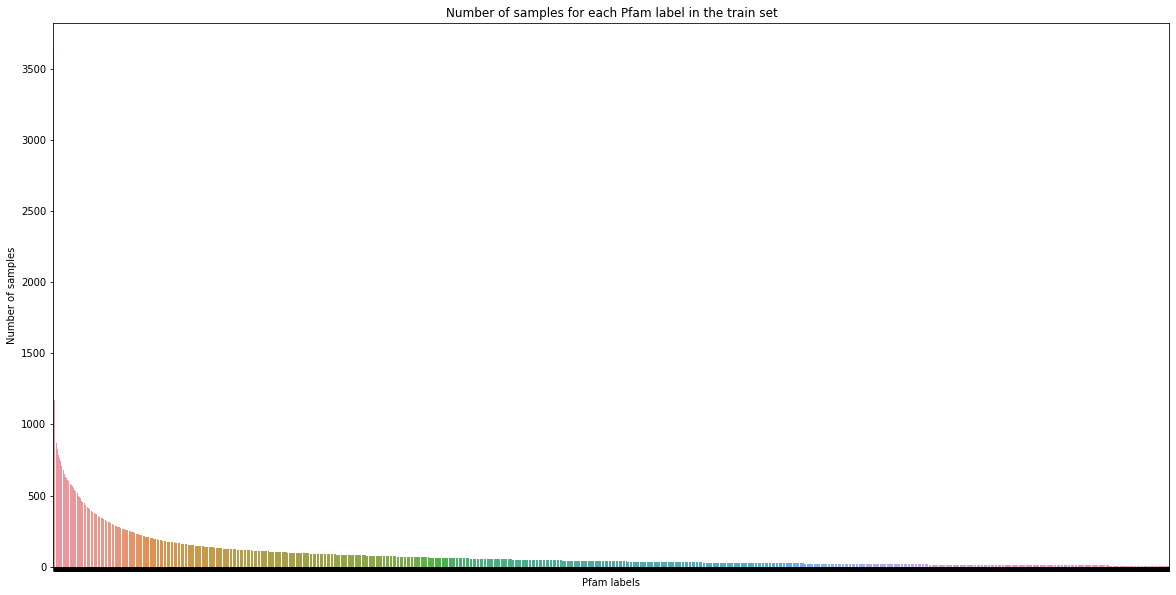

In [ ]:
# Plot sample distribution for each Pfam label
def plot_sample_distribution(df, name):
    plt.figure(figsize=(20,10)) 
    sns.barplot(data=df, x="family_accession", y="sequence_count").set(xticklabels=[])
    plt.title(f'{name}')
    plt.xlabel('Pfam labels')
    plt.ylabel('Number of samples')
    plt.show()

plot_sample_distribution(train_label_count, 'Number of samples for each Pfam label in the train set')

### **Dataset analysis results**

**Observations**
* The Pfam database involves over a million samples and 17,929 protein family categories, bringing the Pfam classification task closer to extreme multi-label classification (XMLC).
* The protein family labels involved in the development and testing set are all included in the train set.
* The distribution of training instances among protein family labels exhibits a long tail (tail labels), suggesting that a large proportion of labels have a small number of instances (79% of labels have less than 100 training instances).


**Solutions**
* As there are only a few training instances in the tail labels, a pre-trained bidirectional Transformer for protein language representation could be a suitable solution as it can achieve good performance with fewer instances.

* Furthermore, attention-based Transformer models have been shown to capture features of connecting residues that are far apart in the underlying sequence but spatially close in the 3D structure (Vig et al., 2020), which makes it ideal for classifying protein families based on not only sequence similarity but also structural similarity.

* However, considering the limitation of computing power, only partial Pfam families and related instances are selected for model demonstration. The selection criteria are as follows:


> 1. Keep the Pfam families included in all splits.
> 2. Pfam families with only a small number of training instances that may not be representative enough are temporarily ignored.
> 3. To avoid selection bias, we randomly sample a part of the Pfam families and check whether the selected ones were sufficiently representative (e.g., the sequence length distribution remains similar).
> 4. As pre-trained transformer models require fewer training instances, random undersampling is also used to reduce computational requirements.

### **Data preparation**

After dataset analysis, the protein family labels and related samples are narrowed according to the criteria above, as well as the number of Pfam classes and the minimum sample size given below (default settings: 1000 Pfam classes and 50 minimum sample size).

In [ ]:
# Enter desired number of Pfam classes to sample and minimum sample size
expected_label_number = int(input('Number of Pfam classes to sample: ') or '1000')
min_sample_number = int(input('Minimum sample size for each Pfam: ') or '50')

Number of Pfam classes to sample: 
Minimum sample size for each Pfam: 


In [ ]:
# Filter out Pfam classes with less than minimum sample number
train_label_count = train_label_count[train_label_count.sequence_count>min_sample_number]
train_label_count

,family_accession,sequence_count
9538,PF13649.6,3637
487,PF00560.33,1927
9411,PF13508.7,1761
4560,PF06580.13,1537
1832,PF02397.16,1528
...,...,...
6819,PF09931.9,51
1992,PF02629.19,51
10278,PF14538.6,51
7078,PF10238.9,51


In [ ]:
# Calculate sequence length for each training instance
train_sampled['sequence_length'] = train_sampled[['sequence']].applymap(lambda x: len(x))
train_sampled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...,124
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...,201
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE,44
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,115
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...,98
...,...,...,...,...,...,...
13405,DUF111,LARC_CLOK5/4-390,PF01969.17,LYYDCF.CGI......SGDMNLAALIDL....G...VPKE..YLME...,LYYDCFCGISGDMNLAALIDLGVPKEYLMEELSKVNLNSEYEMKIE...,387
13406,VAPB_antitox,B9LNT2_HALLT/4-66,PF02697.14,KTISLDEEAYERLKSHKR.EGESFSDVVKRIAG...ERS......W...,KTISLDEEAYERLKSHKREGESFSDVVKRIAGERSWTEVAGILSED...,63
13407,DUF2058,K0C048_CYCSP/5-179,PF09831.9,SLQDQLLKAGLTSKSKAHKAKTQK....HKQIKQKQK.NK.........,SLQDQLLKAGLTSKSKAHKAKTQKHKQIKQKQKNKIQVVDQAAVLA...,175
13408,ADC,A7MRS2_VIBCB/35-269,PF06314.11,GMPVQQGN...SAYTVAPNRFV.....NREYFIITYETDPDALERV...,GMPVQQGNSAYTVAPNRFVNREYFIITYETDPDALERVLPPGLEAP...,235


In [ ]:
# Calculate mean length for each Pfam label
train_label_count = pd.merge(train_label_count, 
                             train_sampled.groupby(['family_accession']).mean().round(0).astype(int).reset_index(drop = False).sort_values(by=['sequence_length']), 
                             on='family_accession')
train_label_count

,family_accession,sequence_count,sequence_length
0,PF13649.6,3637,95
1,PF00560.33,1927,23
2,PF13508.7,1761,85
3,PF06580.13,1537,80
4,PF02397.16,1528,186
...,...,...,...
5431,PF09931.9,51,164
5432,PF02629.19,51,96
5433,PF14538.6,51,152
5434,PF10238.9,51,151


In [ ]:
# Random sampling of Pfam labels
train_label_sampled = train_label_count.sample(n=expected_label_number)
train_label_sampled

,family_accession,sequence_count,sequence_length
101,PF05524.13,704,122
5105,PF03738.14,56,377
1044,PF01293.20,217,466
1189,PF17125.5,194,89
3757,PF17653.1,77,47
...,...,...,...
4582,PF08151.12,64,51
728,PF06130.12,289,74
1720,PF13400.6,145,49
3428,PF10418.9,83,40


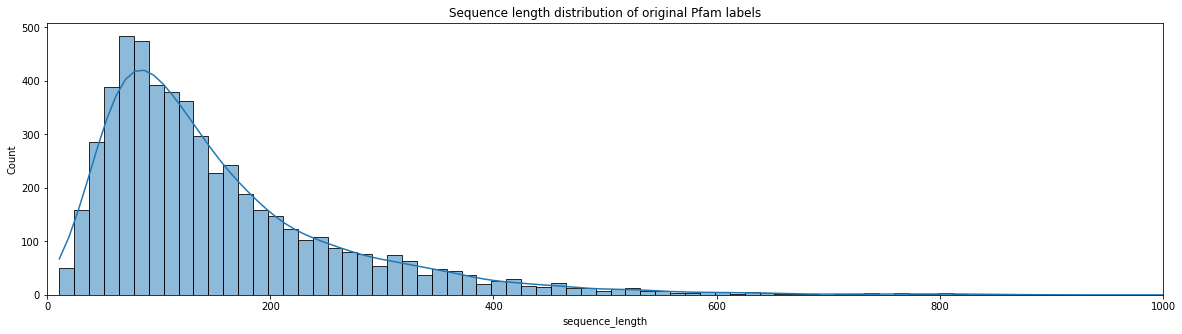

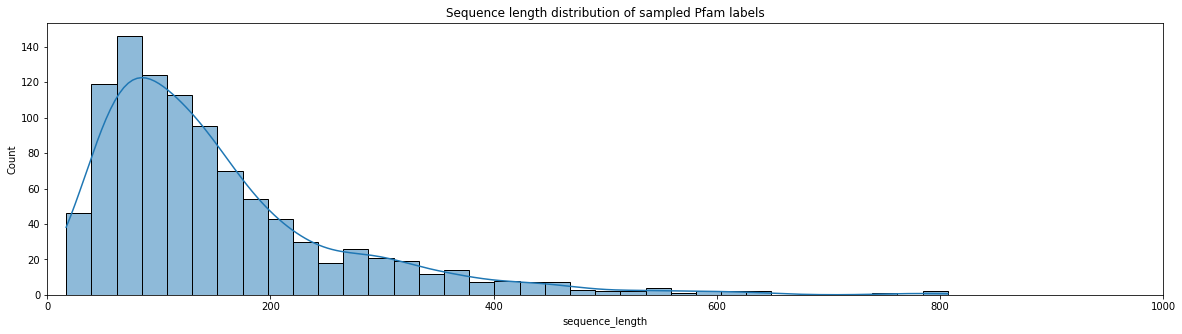

In [ ]:
# Compare sequence length distributions between original and sampled labels
def plot_length_distribution(df, name):
    """
    Plot sequence length distribution for Pfam labels
    """
    plt.figure(figsize=(20,5)) 
    sns.histplot(data=df, x="sequence_length", kde=True)
    plt.xlim(0,1000)
    plt.title(f'{name}')
    plt.show()

plot_length_distribution(train_label_count, 'Sequence length distribution of original Pfam labels')
plot_length_distribution(train_label_sampled, 'Sequence length distribution of sampled Pfam labels')

In [ ]:
# Keep samples with sampled labels
train_sampled = train_sampled[['family_accession', 'sequence_name', 'sequence']][train_sampled.family_accession.isin(train_label_sampled.family_accession.values)]
dev_sampled = dev[['family_accession', 'sequence_name', 'sequence']][dev.family_accession.isin(train_label_sampled.family_accession.values)]
test_sampled = test[['family_accession', 'sequence_name', 'sequence']][test.family_accession.isin(train_label_sampled.family_accession.values)]

In [ ]:
# Data statistics after sampling
splits = {'train_sampled': train_sampled, 'dev_sampled': dev_sampled, 'test_sampled': test_sampled}
sample_total = len(train_sampled) + len(dev_sampled) + len(test_sampled)
for split_name, df in splits.items():
    print('Dataset %s -- sample number: %d, class count: %d, sample size ratio: %f' \
          % (split_name, len(df), len(df.family_accession.value_counts()), len(df) / sample_total * 100))

Dataset train_sampled -- sample number: 161633, class count: 1000, sample size ratio: 80.438840
Dataset dev_sampled -- sample number: 19653, class count: 1000, sample size ratio: 9.780580
Dataset test_sampled -- sample number: 19653, class count: 1000, sample size ratio: 9.780580


In [ ]:
# Function for random undersampling of data
def undersample(df):
    rus = RandomUnderSampler(sampling_strategy='not minority')
    X_us, y_us = rus.fit_resample(df[['sequence_name', 'sequence']], df['family_accession'])
    X_us['family_accession']= y_us

    return X_us

In [ ]:
# Perform random aundersampling
train_sampled = undersample(train_sampled)
dev_sampled = undersample(dev_sampled)
test_sampled = undersample(test_sampled)

In [ ]:
# Data statistics after undersampling
splits = {'train_sampled': train_sampled, 'dev_sampled': dev_sampled, 'test_sampled': test_sampled}
sample_total = len(train_sampled) + len(dev_sampled) + len(test_sampled)
for split_name, df in splits.items():
    print('Dataset %s -- sample number: %d, class count: %d, sample size ratio: %f' \
          % (split_name, len(df), len(df.family_accession.value_counts()), len(df) / sample_total * 100))

Dataset train_sampled -- sample number: 51000, class count: 1000, sample size ratio: 80.952381
Dataset dev_sampled -- sample number: 6000, class count: 1000, sample size ratio: 9.523810
Dataset test_sampled -- sample number: 6000, class count: 1000, sample size ratio: 9.523810


### **Data preparation summary**

* After completing the label sampling and undersampling work, 1,000 Pfam family labels and 51,000 training instances are selected for the subsequent model demonstration.

* The sequence feature (here, we use sequence length distribution for evaluation) of the sampled protein family labels still retains a high similarity, indicating that although only partial labels are selected, the proposed solution may still be applied to other Pfam families with diverse sequence lengths (or even different sequence features).

* Protein sequences will be used as input for Pfam classification, and the family accession will be the prediction of our model.

* The dev set and test set each has 6,000 samples for model evaluation after sampling.

## **Method explanation**

The classification of Pfam families is mainly based on sequence homology, and proteins from the same family also share similar structures and functions. However, as the sequence regions that constitute the main structure and function of proteins are relatively conserved, with the evolution of proteins, it may not be easy to detect only from the sequence similarity even when the protein structure and function similarity still exist. Therefore, in addition to the direct use of sequences for Pfam classification, It would also be interesting to use a higher-order structure prediction derived from sequences as another input for the classification task.

Due to the previous observation that there are fewer training instances for Pfam tail labels, pre-trained Transformer models are expected to reduce sample requirements by leveraging transfer learning. Meanwhile, attention-based Transformer models are better at capturing long-range dependencies, which is well suited for protein family classification as it relies not only on sequence similarity but also spatial structural similarity (Ofer et al., 2021).

## **Experiment Description**

Several Transformer-based models have been presented in recent years, including ESM (Rives et al., 2021), TAPE (Rao et al., 2019) and ProtTrans (Elnaggar et al., 2020), where the ProtTrans models are currently available in HuggingFace. Therefore, we adopt one of the ProtTrans models, encoder-only ProtT5-XL-UniRef50, which is suitable for amino-acid/protein embedding creation and feature extraction. The output vector representations will then be fed into the downstream network to complete the Pfam classification task. The encoder-only ProtT5-XL-UniRef50 model is accessible from [here](https://huggingface.co/Rostlab/prot_t5_xl_half_uniref50-enc) and its code demonstration can be found [here](https://colab.research.google.com/drive/1TUj-ayG3WO52n5N50S7KH9vtt6zRkdmj?usp=sharing#scrollTo=ET2v51slC5ui). 

The encoder-only ProtT5-XL-UniRef50 model also provides both global prediction (per-protein level) and local prediction (per-residue level). While global prediction outputs embeddings through average pooling over the entire protein sequence, in local prediction, per-residue embeddings are fed into a two-layer convolutional neural network (CNN) for secondary structure prediction. Therefore, two different protein structure information, primary sequence embedding and residue-based secondary structure prediction will serve as input to the downstream classification neural network.

The schematic of the experimental design:










### **Data preprocessing**
Data preprocessing for subsequent model fitting and testing.

In [ ]:
# Prepare input data in dict format embedding extraction
train_seq = dict(zip(train_sampled.sequence_name, train_sampled.sequence))
dev_seq = dict(zip(dev_sampled.sequence_name, dev_sampled.sequence))
test_seq = dict(zip(test_sampled.sequence_name, test_sampled.sequence))

In [ ]:
# One-hot encoding for Pfam labels
labels = [[x] for x in train_label_sampled.family_accession.values.tolist()]
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot = encoder.fit(np.asarray(labels))
train_labels_onehot = np.vstack(train_sampled.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list())
dev_labels_onehot = np.vstack(dev_sampled.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list())
test_labels_onehot = np.vstack(test_sampled.family_accession.apply(lambda x: encoder.transform([[x]])[0]).to_list())

In [ ]:
# Check one-hot encoding results
print('train label encoding:', train_labels_onehot.shape)
print('dev label encoding:', dev_labels_onehot.shape)
print('test label encoding:', test_labels_onehot.shape)

train label encoding: (51000, 1000)
dev label encoding: (6000, 1000)
test label encoding: (6000, 1000)


### **Protein language model setup**
The encoder-only ProtT5-XL-UniRef50 model is used as our language model to generate embeddings. Source code can be found [here](https://colab.research.google.com/drive/1TUj-ayG3WO52n5N50S7KH9vtt6zRkdmj?usp=sharing#scrollTo=ET2v51slC5ui).

In [ ]:
# Setup working directories
!mkdir protT5  # root directory for storing checkpoint and results
!mkdir protT5/protT5_checkpoint  # directory holding the ProtT5 checkpoint
!mkdir protT5/sec_struct_checkpoint  # directory storing the supervised classifier's checkpoint
!mkdir protT5/output  # directory for storing your embeddings & predictions
!wget -nc -P protT5/sec_struct_checkpoint http://data.bioembeddings.com/public/embeddings/feature_models/t5/secstruct_checkpoint.pt

--2022-10-20 18:24:22--  http://data.bioembeddings.com/public/embeddings/feature_models/t5/secstruct_checkpoint.pt
Resolving data.bioembeddings.com (data.bioembeddings.com)... 143.95.108.236
Connecting to data.bioembeddings.com (data.bioembeddings.com)|143.95.108.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3727951 (3.6M)
Saving to: ‘protT5/sec_struct_checkpoint/secstruct_checkpoint.pt’

secstruct_checkpoin 100%[===================>]   3.55M  1.93MB/s    in 1.8s    

2022-10-20 18:24:24 (1.93 MB/s) - ‘protT5/sec_struct_checkpoint/secstruct_checkpoint.pt’ saved [3727951/3727951]



In [ ]:
# Define desired outputs: per-protein embeddings (1024-d vector per protein) and secondary structure prediction
per_protein = True
per_protein_path = "./protT5/output/per_protein_embeddings.h5" # where to store the embeddings
sec_struct = True
sec_struct_path = "./protT5/output/sec_struct_preds.h5" # where to store predictions

In [ ]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cuda:0


In [ ]:
# Convolutional neural network for secondary structure prediction
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # CNN weights are trained on ProtT5 embeddings
        self.elmo_feature_extractor = torch.nn.Sequential(
                        torch.nn.Conv2d(1024, 32, kernel_size=(7,1), padding=(3,0)), # 7x32
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.25),
                        )
        n_final_in = 32
        self.dssp3_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d(n_final_in, 3, kernel_size=(7,1), padding=(3,0)) # 7
                        )
        
        self.dssp8_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d(n_final_in, 8, kernel_size=(7,1), padding=(3,0))
                        )
        self.diso_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d(n_final_in, 2, kernel_size=(7,1), padding=(3,0))
                        )
        

    def forward(self, x):
        # IN: X = (B x L x F); OUT: (B x F x L, 1)
        x = x.permute(0,2,1).unsqueeze(dim=-1) 
        x         = self.elmo_feature_extractor(x) # OUT: (B x 32 x L x 1)
        d3_Yhat   = self.dssp3_classifier(x).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 3)
        d8_Yhat   = self.dssp8_classifier(x).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 8)
        diso_Yhat = self.diso_classifier(x).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 2)
        return d3_Yhat, d8_Yhat, diso_Yhat

In [ ]:
# Load the checkpoint for secondary structure prediction
def load_sec_struct_model():
    checkpoint_dir="./protT5/sec_struct_checkpoint/secstruct_checkpoint.pt"
    state = torch.load(checkpoint_dir)
    model = ConvNet()
    model.load_state_dict(state['state_dict'])
    model = model.eval()
    model = model.to(device)
    print('Loaded sec. struct. model from epoch: {:.1f}'.format(state['epoch']))

    return model

In [ ]:
# Load encoder-part of ProtT5-XL-U50 in half-precision
def get_T5_model():
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc")
    model = model.to(device) # move model to GPU
    model = model.eval() # set model to evaluation model
    tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

    return model, tokenizer

In [ ]:
# Generate embeddings
def get_embeddings(model, tokenizer, seqs, per_protein, sec_struct, max_residues=4000, max_seq_len=1000, max_batch=100):

    if sec_struct:
        sec_struct_model = load_sec_struct_model()

    results = {"protein_embs" : dict(), "sec_structs" : dict()}

    seq_dict = sorted(seqs.items(), key=lambda kv: len(seqs[kv[0]]), reverse=True)
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict,1):
        seq = seq
        seq_len = len(seq)
        seq = ' '.join(list(seq))
        batch.append((pdb_id,seq,seq_len))

        n_res_batch = sum([ s_len for  _, _, s_len in batch ]) + seq_len 
        if len(batch) >= max_batch or n_res_batch>=max_residues or seq_idx==len(seq_dict) or seq_len>max_seq_len:
            pdb_ids, seqs, seq_lens = zip(*batch)
            batch = list()

            token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
            
            try:
                with torch.no_grad():
                    embedding_repr = model(input_ids, attention_mask=attention_mask)
            except RuntimeError:
                print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
                continue

            if sec_struct: 
                d3_Yhat, d8_Yhat, diso_Yhat = sec_struct_model(embedding_repr.last_hidden_state)

            for batch_idx, identifier in enumerate(pdb_ids): 
                s_len = seq_lens[batch_idx]
                emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
                if per_protein:  
                    protein_emb = emb.mean(dim=0)
                    results["protein_embs"][identifier] = protein_emb.detach().cpu().numpy().squeeze()
                if sec_struct:  
                    results["sec_structs"][identifier] = torch.max(d3_Yhat[batch_idx,:s_len], dim=1)[1].detach().cpu().numpy().squeeze()

    passed_time = time.time()-start
    avg_time = passed_time/len(results["protein_embs"])
    print('\n############# EMBEDDING STATS #############')
    print('Total number of per-protein embeddings: {}'.format(len(results["protein_embs"])))
    print("Time for generating embeddings: {:.1f}[m] ({:.3f}[s/protein])".format(passed_time/60, avg_time ))
    print('\n############# END #############')

    return results

### **Embedding extraction and structure prediciton**
Here we use the language model to extract protein features, including per-sequence embeddings through global pooling, and per-residue secondary structure predictions.

In [ ]:
# Load ProtT5-XL-U50 encoder
model, tokenizer = get_T5_model()
start = time.time()
train_embedding = get_embeddings(model, tokenizer, train_seq, per_protein, sec_struct)
dev_embedding = get_embeddings(model, tokenizer, dev_seq, per_protein, sec_struct)
test_embedding = get_embeddings(model, tokenizer, test_seq, per_protein, sec_struct)
end = time.time()
print('Execution time: {} seconds'.format(end - start))

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/238k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Loaded sec. struct. model from epoch: 18.0

############# EMBEDDING STATS #############
Total number of per-protein embeddings: 51000
Time for generating embeddings: 93.3[m] (0.110[s/protein])

############# END #############
Loaded sec. struct. model from epoch: 18.0

############# EMBEDDING STATS #############
Total number of per-protein embeddings: 6000
Time for generating embeddings: 11.0[m] (0.110[s/protein])

############# END #############
Loaded sec. struct. model from epoch: 18.0

############# EMBEDDING STATS #############
Total number of per-protein embeddings: 6000
Time for generating embeddings: 11.0[m] (0.110[s/protein])

############# END #############
Execution time: 6924.039359092712 seconds


In [ ]:
# Re-order embeddings and secondary structure predictions
train_embedding["protein_embs"] = {x: train_embedding["protein_embs"][x] for x in train_sampled.sequence_name.to_list()}
dev_embedding["protein_embs"] = {x: dev_embedding["protein_embs"][x] for x in dev_sampled.sequence_name.to_list()}
test_embedding["protein_embs"] = {x: test_embedding["protein_embs"][x] for x in test_sampled.sequence_name.to_list()}

train_embedding["sec_structs"] = {x: train_embedding["sec_structs"][x] for x in train_sampled.sequence_name.to_list()}
dev_embedding["sec_structs"] = {x: dev_embedding["sec_structs"][x] for x in dev_sampled.sequence_name.to_list()}
test_embedding["sec_structs"] = {x: test_embedding["sec_structs"][x] for x in test_sampled.sequence_name.to_list()}

In [ ]:
# Check sequence orders for protein embeddings and secondary structure predictions
print('Sequence orders of protein embeddings are the same: ', list(train_seq.keys()) == list(train_embedding["protein_embs"].keys()))
print('Sequence orders of secondary structure predictions are the same: ', list(train_seq.keys()) == list(train_embedding["sec_structs"].keys()))

Sequence orders of protein embeddings are the same:  True
Sequence orders of secondary structure predictions are the same:  True


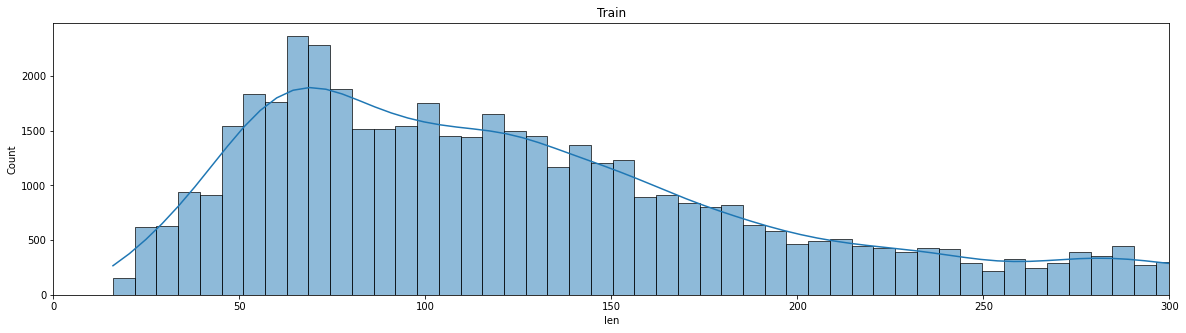

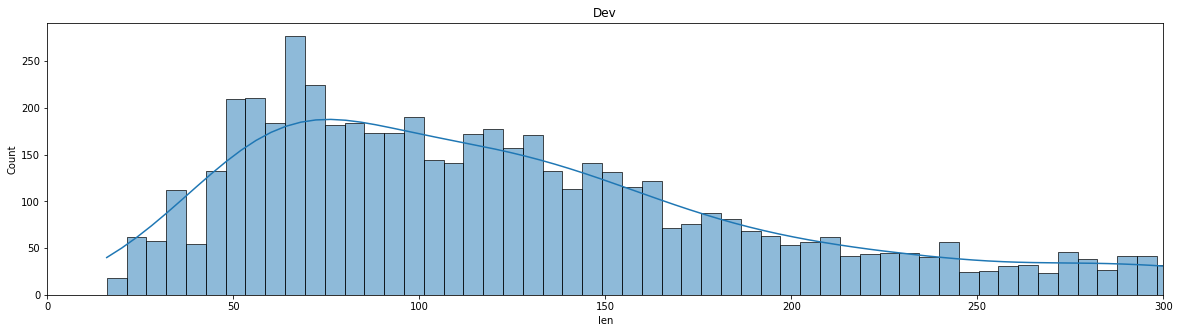

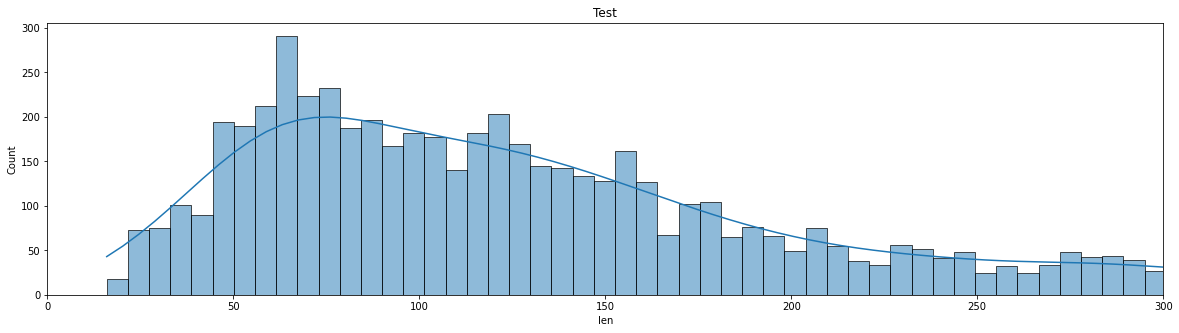

In [ ]:
# Check length distribution of secondary structure class prediction (H, E, and L)
train_struct_len = pd.DataFrame([len(x) for x in list(train_embedding['sec_structs'].values())], columns=['len'])
dev_struct_len = pd.DataFrame([len(x) for x in list(dev_embedding['sec_structs'].values())], columns=['len'])
test_struct_len = pd.DataFrame([len(x) for x in list(test_embedding['sec_structs'].values())], columns=['len'])

def plot_struct_len(df, name):
    plt.figure(figsize=(15,5)) 
    sns.histplot(data=df, x="len", kde=True, bins=150)
    plt.xlim(0,400)
    plt.title(f'{name}')
    plt.show()

plot_struct_len(train_struct_len, 'Train')
plot_struct_len(dev_struct_len, 'Dev')
plot_struct_len(test_struct_len, 'Test')

In [ ]:
# Function to preprocess secondary structure class prediction
def convert_and_pad_sec_structs(embedding_dict):
    """
    Covert predictions into none-zero digits and pad with 0 if sequence length is less than max_length
    :return: an array with processed values
    """
    class_mapping = {0:1,1:2,2:3}  # {0:"H",1:"E",2:"L"}
    for seq_id, yhat in embedding_dict['sec_structs'].items():
        yhat_new = []
        for j in yhat:
            yhat_new.append(class_mapping[j])
        embedding_dict['sec_structs'][seq_id] = np.array(yhat_new)

    arr_padded = keras.utils.pad_sequences(embedding_dict['sec_structs'].values(), 
                                           maxlen=100, 
                                           dtype='int32', 
                                           padding='post', 
                                           value=0)
    return arr_padded

In [ ]:
# Process secondary structure prediction
train_pad = convert_and_pad_sec_structs(train_embedding)
dev_pad = convert_and_pad_sec_structs(dev_embedding)
test_pad = convert_and_pad_sec_structs(test_embedding)
print('train secondary struct shape:', train_pad.shape)
print('dev secondary struct shape:', dev_pad.shape)
print('test secondary struct shape:', test_pad.shape)

train secondary struct shape: (51000, 100)
dev secondary struct shape: (6000, 100)
test secondary struct shape: (6000, 100)


In [ ]:
# Create input matrices from protein sequence embedding and secondary structure prediction
X_train = np.vstack(list(train_embedding['protein_embs'].values()))
X_dev = np.vstack(list(dev_embedding['protein_embs'].values()))
X_test = np.vstack(list(test_embedding['protein_embs'].values()))

X_train_sec = np.vstack(train_pad)
X_dev_sec = np.vstack(dev_pad)
X_test_sec = np.vstack(test_pad)

In [ ]:
# Output principle components using t-SNE
X_embedded = TSNE(n_components=2, random_state=42, perplexity=50.0).fit_transform(X_train)
train_sampled['PC1'] = X_embedded[:,0]
train_sampled['PC2'] = X_embedded[:,1]

X_embedded_sec = TSNE(n_components=2, random_state=42, perplexity=50.0).fit_transform(X_train_sec)
train_sampled['PC1_sec'] = X_embedded_sec[:,0]
train_sampled['PC2_sec'] = X_embedded_sec[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 0.98, 't-SNE projections of secondary structure prediction')

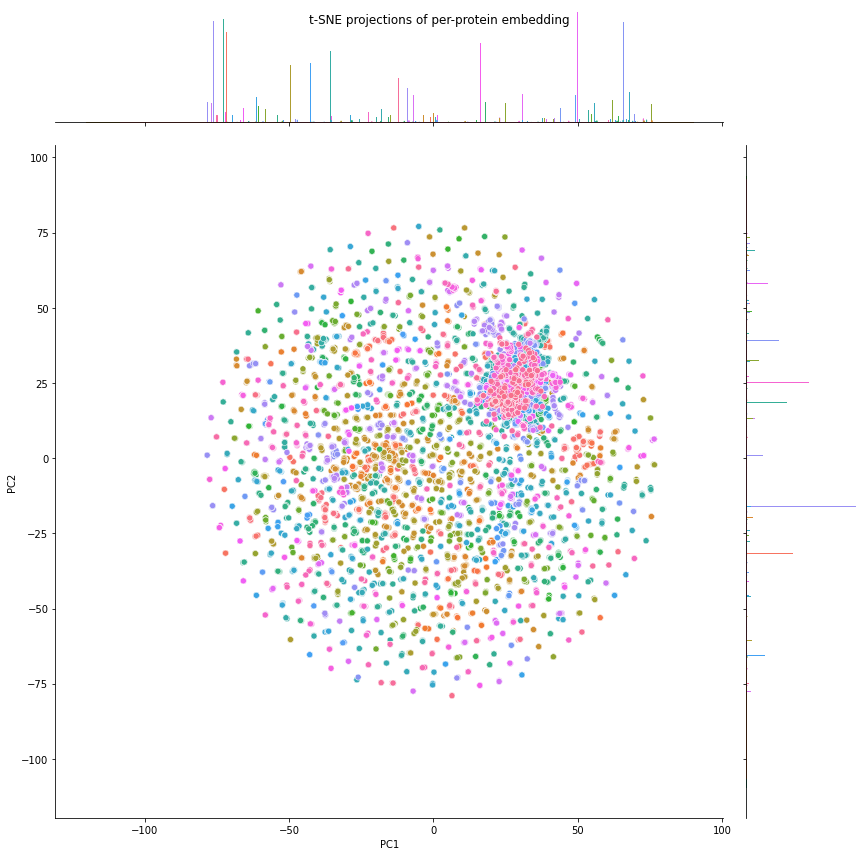

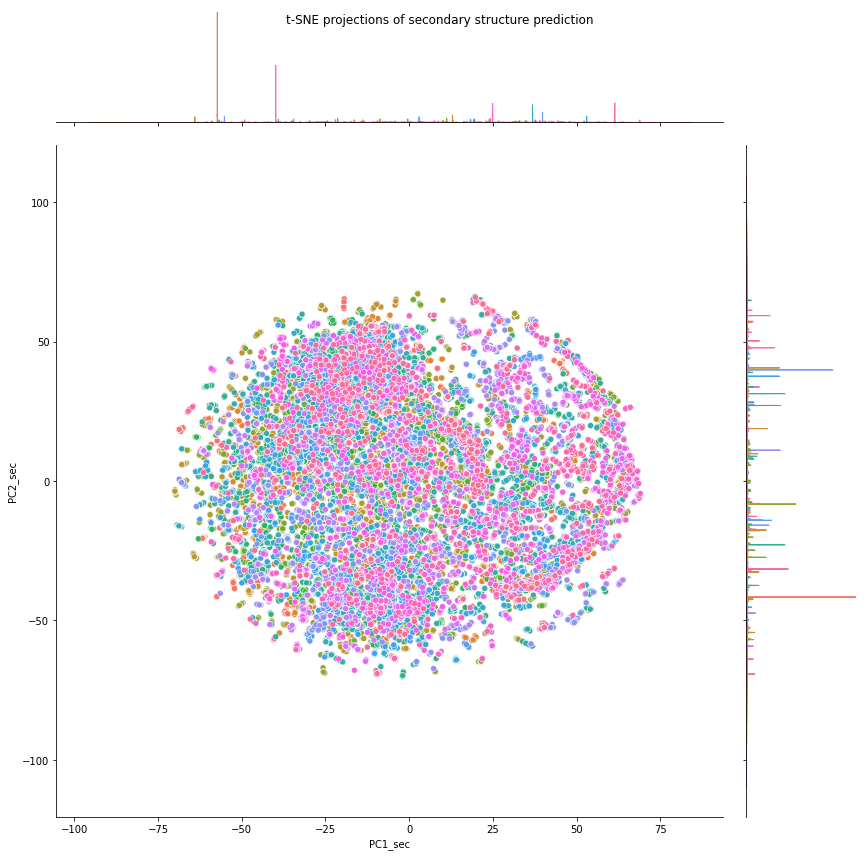

In [ ]:
# Visualize t-SNE projection
sns.jointplot(data=train_sampled, x='PC1', y='PC2', hue='family_accession', height=12).ax_joint.legend_.remove()
plt.suptitle("t-SNE projections of per-protein embedding")

sns.jointplot(data=train_sampled, x='PC1_sec', y='PC2_sec', hue='family_accession', height=12).ax_joint.legend_.remove()
plt.suptitle("t-SNE projections of secondary structure prediction")

### **Downstream model architecture**
As the language model has completed the most challenging task - protein sequence feature extraction and secondary structure prediction, here we create a simple neural network to receive the output from the language model and categorise features for protein family classification.

In [ ]:
# Downstream network for classification
def get_downstream_model(input_shape):
    """
    Downstream model architecture
    """
    input = keras.layers.Input(shape=input_shape)
    hidden1 = keras.layers.Dense(200, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-3))(input)
    hidden2 = keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-3))(hidden1)
    output = keras.layers.Dense(expected_label_number, activation='softmax')(hidden2)

    model = keras.models.Model(inputs=[input], outputs=output)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    model.summary()
    
    return model

In [ ]:
# Apply early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Function to plot loss
def plot_loss(history):
    """
    Plot loss history
    """
    pd.DataFrame(history.history).plot(figsize=(10,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

In [ ]:
# Function to evaluate model performance
def evaluate_performance(y_true, y_pred):
    """
    Compute and print out precision, recall and f1-score
    """
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    result = classification_report(y_true, y_pred, output_dict=True)['macro avg']
    print('Precision: ', result['precision'])
    print('Recall: ', result['recall'])
    print('F1-score: ', result['f1-score'])

### **Model fitting with sequence embeddings**
First, we train the classification neural network using the embedding of the entire protein sequence as input.

In [ ]:
# Classification based on embeddings of sequences
model = get_downstream_model(1024)
history = model.fit(X_train, train_labels_onehot, 
                    validation_data=(X_dev, dev_labels_onehot), 
                    epochs=50,
                    verbose=2,
                    callbacks=[callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 200)               205000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1000)              101000    
                                                                 
Total params: 326,100
Trainable params: 326,100
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1594/1594 - 6s - loss: 2.5338 - val_loss: 1.1566 - 6s/epoch - 4ms/step
Epoch 2/50
1594/1594 - 5s - loss: 1.0300 - val_loss: 0.9089 - 5s/epoch - 3ms/step
Epoch 3/50
1594/1594 - 

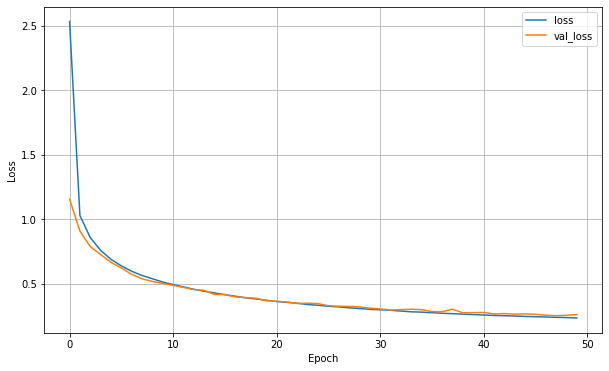

In [ ]:
# Plot loss history
plot_loss(history)

In [ ]:
# Prediction and evaluation
test_preds = model.predict(X_test)
evaluate_performance(test_labels_onehot, test_preds)

188/188 [==============================] - 0s 2ms/step
Precision:  0.981796855921856
Recall:  0.9748333333333333
F1-score:  0.975479339193658


### **Model fitting with secondary structure prediction**

Likewise, we train the classification neural network using the predicted secondary structure based on each amino acid residue. The difference is that additional dropout layers are added to the original model architecture due to the previously observed overfitting.

In [ ]:
# Downstream network for classification (with dropout layers)
def get_downstream_model(input_shape):
    """
    Downstream model architecture
    """
    input = keras.layers.Input(shape=input_shape)
    hidden1 = keras.layers.Dense(200, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-3))(input)
    drop1 = keras.layers.Dropout(0.2)(hidden1)
    hidden2 = keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-3))(drop1)
    drop2 = keras.layers.Dropout(0.1)(hidden2)
    Output = keras.layers.Dense(expected_label_number, activation='softmax')(drop2)

    model = keras.models.Model(inputs=[input], outputs=Output)
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    model.summary()
    
    return model

In [ ]:
# Classification based on secondary structure prediction
model_sec = get_downstream_model(100)
history_sec = model_sec.fit(X_train_sec, train_labels_onehot, 
                            validation_data=(X_dev_sec, dev_labels_onehot), 
                            epochs=50, 
                            verbose=2,
                            callbacks=[callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1000)              101000    
                                                                 
Total params: 141,300
Trainable params: 141,300
Non-trainab

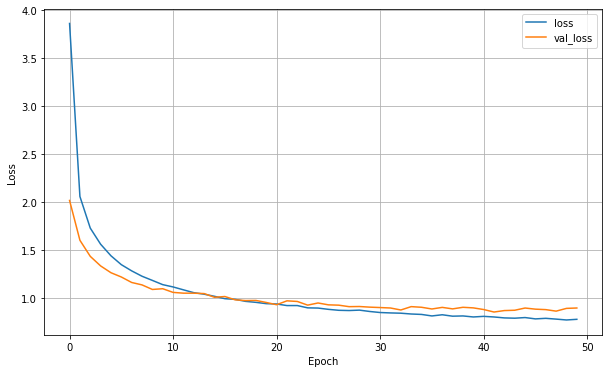

In [ ]:
# Plot loss history
plot_loss(history_sec)

In [ ]:
# Prediction and model evaluation
test_preds_sec = model_sec.predict(X_test_sec)
evaluate_performance(test_labels_onehot, test_preds_sec)

188/188 [==============================] - 0s 2ms/step
Precision:  0.8828207431457431
Recall:  0.8683333333333334
F1-score:  0.8627163186486716


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Result analysis**

This experiment attempts to use sequences as model input and predict its Pfam family category. Considering the number of samples in most Pfam families is small, we use the pre-trained, Transformer-based protein language model for embedding prediction and the following classification task. Two levels of embedding predictions are employed, including sequence embedding that integrates information from the complete protein, and secondary structure prediction based on per-residue embeddings.

In the classification task based on global sequence embeddings, the pre-trained language model gives an impressive performance on embedding prediction and the Pfam classification task (F1-score of 0.98), considering it performs the 1000-family prediction task with only 50 training instances per class.

However, the class prediction using the secondary structure prediction obtains an F1-score of 0.86, with additional dropout layers added to the downstream model to cope with overfitting. This is unsirprising, as we can see in t-SNE projection, global sequence embeddings produce more visually separable clusters in 2D space compared to secondary structure prediction, especially when the number of Pfam classes increases dramatically (from previous test results, data not shown). The reasons may be as follows:

1. The Transformer model's attention mechanism helps capture the dependencies of residues related to conserved motifs. As the global sequence embedding is derived from the average pooling of each residue embedding, it already contains protein spatial information

2. The output of secondary structure prediction is essentially like another set of sequences, except that the sequence composition is converted from amino acid residues to secondary structure abbreviations (alpha helices, beta sheets, and loops). Although the output result has simpler and clearer secondary structural information, it cannot keep leveraging transfer learning based on 45 million protein datasets in the subsequent classification task. It may require more data and a deeper downstream neural network.

Finally, as the diversity and representativeness of sequence training instances are considered during sampling, the selected samples have a sequence length distribution highly similar to before sampling. Therefore, if the number of Pfam labels is scaled up when the computing power allows, the proposed model is still expected to provide high performance on the Pfam classification task.

## **Reference**

1. Elnaggar, A., Heinzinger, M., Dallago, C., Rihawi, G., Wang, Y., Jones, L., & Rost, B. (2020). ProtTrans: towards cracking the language of Life's code through self-supervised deep learning and high performance computing. arXiv preprint arXiv:2007.06225.
2. Ofer, D., Brandes, N., & Linial, M. (2021). The language of proteins: NLP, machine learning & protein sequences. Computational and Structural Biotechnology Journal, 19, 1750-1758.
3. Rao, R., Bhattacharya, N., Thomas, N., Duan, Y., Chen, P., Canny, J., & Song, Y. (2019). Evaluating protein transfer learning with TAPE. Advances in neural information processing systems, 32.
4. Rives, A., Meier, J., Sercu, T., Goyal, S., Lin, Z., Liu, J., & Fergus, R. (2021). Biological structure and function emerge from scaling unsupervised learning to 250 million protein sequences. Proceedings of the National Academy of Sciences, 118(15), e2016239118.
5. Rostlab/prot_t5_xl_half_uniref50-enc · Hugging Face https://huggingface.co/Rostlab/prot_t5_xl_half_uniref50-enc (Accessed on 20/10/2022).
6. Vig, J., Madani, A., Varshney, L. R., Xiong, C., Socher, R., & Rajani, N. F. (2020). BERTology meets biology: interpreting attention in protein language models. arXiv preprint arXiv:2006.15222.